# Refit rheology and generate values in ASPECT

Here I summarized what I learned from refiting the prefactor A after both E and V are varied.
Afterwards, I generate mantle profiles and lithospheric strengh with these rheology.
This typically summarizes the workflow to make change to a published flow law, incoporate the parameterization into ASPECT, as well as generate figures to be attached in publications.

In this notebook, I took a different approach and condense the modification in $\dot{\epsilon_{correction}}$.
This variable is computed from a original flow law with a experimental referential state.
It is then carried into viscosity calculation to be a modification of $\dot{\epsilon_{correction}}^{1/n}$ 

In [1]:
# Import system modules
import os
import sys
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from matplotlib import gridspec, rcdefaults
from pathlib import Path

# Import package modules
package_root = os.path.abspath(Path().resolve().parent.parent.parent)
LEGACY_FILE_DIR = os.path.join(package_root, "hamageolib/research/haoyuan_2d_subduction", "legacy_files")

sys.path.insert(0, package_root)
from hamageolib.research.haoyuan_2d_subduction.legacy_tools import RHEOLOGY_PRM, RHEOLOGY_OPR, CreepStrainRate,\
    CoulumbYielding, CreepRheologyInAspectViscoPlastic, GetPeierlsRheology, PeierlsCreepStress, PLATE_MODEL,\
    RefitRheology

from hamageolib.utils.plot_helper import MatplotlibFormatPrep

# Gas constant
R = 8.314

# Load the rheology from Warren, Hansen's 2023 paper
By default, I use the flow law variables in Warren, Hansen 2023's table.
The key difference from the Hirth, Kohlstedt 2003 flow law is a change of the prefactor by $3.5^r$. And that's from the updated water calibration from Bell et al 2003. For more detail, refer to the original paper
([https://www.annualreviews.org/content/journals/10.1146/annurev-earth-031621-063756](https://www.annualreviews.org/content/journals/10.1146/annurev-earth-031621-063756))

![](2025-07-18_122352.png)

In [2]:
# read the parameters from HK 03.
# water is in the water fugacity
rheology = "WarrenHansen23"

rheology_prm_dict = RHEOLOGY_PRM()
diffusion_creep_ori = getattr(rheology_prm_dict, rheology + "_diff")
dislocation_creep_ori = getattr(rheology_prm_dict, rheology + "_disl")
rheology_dict = {'diffusion': diffusion_creep_ori, 'dislocation': dislocation_creep_ori}

print("diffusion_creep: ", diffusion_creep_ori)
print("dislocation_creep: ", dislocation_creep_ori)

diffusion_creep:  {'A': 290000.0, 'p': 3.0, 'r': 1.0, 'n': 1.0, 'E': 335000.0, 'V': 4e-06}
dislocation_creep:  {'A': 20, 'p': 0.0, 'r': 1.2, 'n': 3.5, 'E': 480000.0, 'V': 1.1e-05}


# Next: assign a modification

Next, I assign a modification to the original flow law.
The modification is added to the original set of variables.

for example diff_correction

    diff_correction = {'A': 1.0, 'p': 0.0, 'r': 0.0, 'n': 0.0, 'E': 100e3, 'V': 0.0}

we would change the diffusion creep activation energy by 100 Kj/mol from the default value.

The correction['A'] is always set to 1.0.
And for other variables (e.g. For the activation energy):
$E = E_{ori} + E_{correction}$

A reference state is also given:

    stress_ref = 50.0 # MPa
    P_ref = 100.0e6 # Pa
    T_ref = 1250.0 + 273.15 # K
    d_ref = 15.0 # mu m

This measures an experimental condition selected from the original Hirth and Kohlstedt 2003 paper.
The idea is, we should still be able to reproduce this reference state after we modify the flow law.
And it's easy to tell that modify one of the variables (e.g. E) without adjusting the prefactor will break this constraint.

Therefore, a strain_rate_correction term is calculated from the modified flow law and the reference state.
Consequently, this term is used to modify the prefactor in modification of the flow law variables.

In [3]:
# 1.9e-6
# Warren & Hansen 2023
diff_correction = {'A': 1.0, 'p': 0.0, 'r': 0.0, 'n': 0.0, 'E': 100e3, 'V': 0.0}
disl_correction = {'A': 1.0, 'p': 0.0, 'r': 0.0, 'n': 0.0, 'E': 0.0, 'V': 3e-6}

Coh = 500.0 # H / 10^6 Si

# fit new rheology
stress_ref = 50.0 # MPa
P_ref = 100.0e6 # Pa
T_ref = 1250.0 + 273.15 # K
d_ref = 15.0 # mu m

strain_rate_diff_correction = CreepStrainRate(diff_correction, stress_ref, P_ref, T_ref, d_ref, Coh)
strain_rate_disl_correction = CreepStrainRate(disl_correction, stress_ref, P_ref, T_ref, d_ref, Coh)

# screen output
print("strain_rate_diff_correction:", strain_rate_diff_correction) 
print("strain_rate_disl_correction:", strain_rate_disl_correction) 

# apply the correction
diffusion_creep = diffusion_creep_ori.copy()
dislocation_creep = dislocation_creep_ori.copy()

diffusion_creep['E'] += diff_correction['E']
diffusion_creep['V'] += diff_correction['V']
dislocation_creep['E'] += disl_correction['E']
dislocation_creep['V'] += disl_correction['V']
diffusion_creep['A'] /= strain_rate_diff_correction
dislocation_creep['A'] /= strain_rate_disl_correction

# screen output
print("diffusion_creep: ", diffusion_creep)
print("dislocation_creep: ", dislocation_creep)

strain_rate_diff_correction: 0.00037195774883464714
strain_rate_disl_correction: 0.9765882188461675
diffusion_creep:  {'A': np.float64(779658444.8329877), 'p': 3.0, 'r': 1.0, 'n': 1.0, 'E': 435000.0, 'V': 4e-06}
dislocation_creep:  {'A': np.float64(20.479460650907573), 'p': 0.0, 'r': 1.2, 'n': 3.5, 'E': 480000.0, 'V': 1.4e-05}


#### Last: Lower mantle rheology with a jump, plots, profiles

Then I call a function "MantleRheology" to derive the whole mantle rheology profile.
The mantle profile viscosity profile is plotted and saved.
The aspect importable rheology is saved in a dict and then returned (i.e. rheolog_aspect), with two important differences
  1. In this dict object, every value has standard unit (Pa, m, s, ...).
  2. This only has the parameters for ASPECT (e.g. it doesn't has Coh), so all the other effects are taken care off and combined into A.

In [4]:
jump_lower_mantle = 100.0

Operator = RHEOLOGY_OPR()

da_file = os.path.join(LEGACY_FILE_DIR, 'reference_TwoD', "depth_average.txt")
Operator.ReadProfile(da_file)

fig_path = os.path.join(package_root, "dtemp", "%s_coh%.1f_dEdiff%.2e_dVdiff%.2e_dEdisl%.2e_dVdisl%.2e_1"\
                                                 % (rheology, Coh, diff_correction['E'], diff_correction['V'], disl_correction['E'], disl_correction['V']))\
                                                  + ".png"

rheology_aspect, constrained_viscosity_profile = Operator.MantleRheology(assign_rheology=True, diffusion_creep=diffusion_creep, dislocation_creep=dislocation_creep, save_profile=1,\
        use_effective_strain_rate=True, save_json=False, fig_path=fig_path, Coh=Coh, jump_lower_mantle=jump_lower_mantle, save_pdf=True)

depths0 = constrained_viscosity_profile['depth']
viscosity0 = constrained_viscosity_profile['composite']
viscosity0_diff = constrained_viscosity_profile['diffusion']
viscosity0_disl = constrained_viscosity_profile['dislocation']
visc0_func = interp1d(depths0, viscosity0, assume_sorted=True)
visc_diff0_func = interp1d(depths0, viscosity0_diff, assume_sorted=True)
visc_disl0_func = interp1d(depths0, viscosity0_disl, assume_sorted=True)


print("constrained_rheology_aspect (type):", type(rheology_aspect))
print("constrained_rheology_aspect:", rheology_aspect)

New figure: /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/WarrenHansen23_coh500.0_dEdiff1.00e+05_dVdiff0.00e+00_dEdisl0.00e+00_dVdisl3.00e-06_1.png
New figure: /home/lochy/ASPECT_PROJECT/HaMaGeoLib/hamageolib/research/haoyuan_2d_subduction/../../../dtemp/rheology_results/mantle_profile_v1_HK03_wet_mod_dEdiff0.0000e+00_dEdisl0.0000e+00_dVdiff0.000000e+00_dVdisl0.0000e+00_dAdiff1.0000e+00_dAdisl1.0000e+00.pdf
constrained_rheology_aspect (type): <class 'dict'>
constrained_rheology_aspect: {'diffusion_creep': {'A': np.float64(5.847438336247409e-13), 'd': 0.01, 'n': 1.0, 'm': 3.0, 'E': 435000.0, 'V': 4e-06}, 'dislocation_creep': {'A': np.float64(2.101722373657347e-16), 'd': 0.01, 'n': 3.5, 'm': 0.0, 'E': 480000.0, 'V': 1.4e-05}, 'diffusion_lm': {'A': np.float64(9.359849009689505e-16), 'd': 0.01, 'n': 1.0, 'm': 3.0, 'E': 435000.0, 'V': 3e-06}}


## Constrains

## The Haskell 1935 (ice glacial rebound), reviewed by F&M 96

This is the constraint from the so-called Fennoscandian relaxation spectrum (FRS)

The average of the mantle rheology down to 1400 km is somewhere 0.65-1.1e21.

In the following section, I computed an average by the log value between 100 km and 1400 km

In [5]:
# Next, we visit some constraints for whole manlte rheology 
# to see whether we match them
# The haskel constraint
radius = 6371e3
lith_depth = 100e3
integral_depth = 1400e3
mask_integral = (depths0 > lith_depth) & (depths0 < integral_depth)
integral_cores = 4 * np.pi * (radius - depths0)**2.0
# upper mantle
# use harmonic average
# lower mantle
integral = np.trapz(integral_cores[mask_integral] * np.log10(viscosity0[mask_integral]), depths0[mask_integral])
volume = np.trapz(integral_cores[mask_integral], depths0[mask_integral])
average_log_eta = integral / volume
average_eta = 10**average_log_eta

print("Average (by log) over the 1400 km depth: %.4e\n" % average_eta)

# rheology at 250 km depth
depth_switch = 250e3
visc_diff_switch = visc_diff0_func(depth_switch)
visc_disl_switch = visc_disl0_func(depth_switch)
visc_switch = visc0_func(depth_switch)

print("Diffusion creep at %.2d km: %.4e" % (depth_switch, visc_diff_switch))
print("Dislocation creep at %.2d km: %.4e" % (depth_switch, visc_disl_switch))
print("Viscosity at %.2d km: %.4e\n" % (depth_switch, visc_switch))

# lower mantle
depth_lm = 1500e3
visc_lm = visc0_func(depth_lm)
print("Viscosity at %.2d km: %.4e" % (depth_lm, visc_lm))

Average (by log) over the 1400 km depth: 2.7418e+21

Diffusion creep at 250000 km: 3.0074e+20
Dislocation creep at 250000 km: 1.2740e+20
Viscosity at 250000 km: 8.9489e+19

Viscosity at 1500000 km: 2.4487e+22


/tmp/ipykernel_3850305/1334184796.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(integral_cores[mask_integral] * np.log10(viscosity0[mask_integral]), depths0[mask_integral])
/tmp/ipykernel_3850305/1334184796.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  volume = np.trapz(integral_cores[mask_integral], depths0[mask_integral])


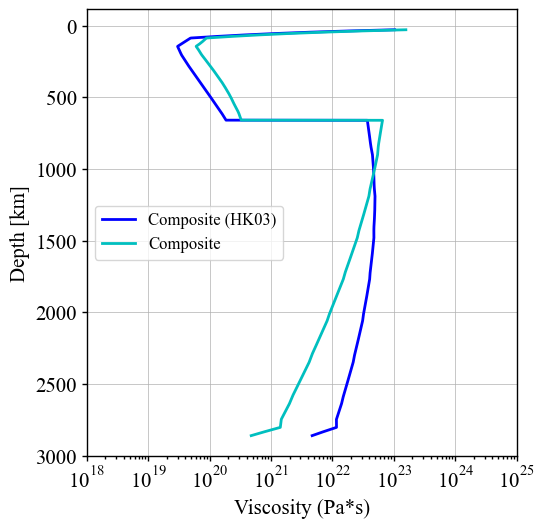

In [6]:
# Make figure better
MatplotlibFormatPrep()

# Compute mantle profile
rheology_aspect_hk03, constrained_viscosity_profile_hk03 = Operator.MantleRheology(rheology="HK03", use_effective_strain_rate=True, save_json=False, Coh=Coh, jump_lower_mantle=jump_lower_mantle)

depths_hk03 = constrained_viscosity_profile_hk03['depth']
viscosity_hk03 = constrained_viscosity_profile_hk03['composite']

visc0_hk03_func = interp1d(depths_hk03, viscosity_hk03, assume_sorted=True)

# Plot
fig = plt.figure(tight_layout=True, figsize=[10, 10])
gs = gridspec.GridSpec(2, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax0.semilogx(viscosity_hk03, depths_hk03/1e3, 'b-', label='Composite (HK03)')
ax0.semilogx(viscosity0, depths0/1e3, 'c-', label='Composite')
ax0.invert_yaxis()
ax0.set_xlim([1e18,1e25])
ax0.grid()
ax0.set_ylabel('Depth [km]')
ax0.set_xlabel("Viscosity (Pa*s)")
ax0.legend()

for spine in ax0.spines.values():
    spine.set_linewidth(1.0)

# Reset Environment
rcdefaults()

# Values in my 2-d paper

Here I apply the idea from the previous sections and use the utility function to derive the
values of flow laws I used in my 2-d paper.

Here the refiting process is handled in the RefitRheology function. And below is a section for the upper mantle rheology in the Material-model part of my prm file:

        set Prefactors for diffusion creep = 2.1392e-16
        set Grain size exponents for diffusion creep = 3.0000e+00
        set Activation energies for diffusion creep = 3.3500e+05
        set Activation volumes for diffusion creep = 1.9000e-06
        set Prefactors for dislocation creep = 2.1017e-16
        set Stress exponents for dislocation creep = 3.5000e+00
        set Activation energies for dislocation creep = 4.8000e+05
        set Activation volumes for dislocation creep = 1.4000e-05

To add the lower mantle rheology, one need a phase transition (PT) at the 660e3. I also included shallower PTs in the mantle transition zone (MTZ). This will look like the section below. The 660-transition is the last in the list. Notice that we vary the values of flow in the last entry of the list, to prescribe a different value for the lower mantle. Also, in order to deactivate the dislocation creep, here the method is to assign a very small prefactor (5e-32), so the viscosity value will be big (1e31) and effectively deactivate it.

        set Phase transition depths = background:410e3|520e3|560e3|660e3
        set Phase transition widths = background:13e3|25e3|60e3|5e3
        set Phase transition temperatures = background:1780.0|1850.0|1870.0|1910.0
        set Phase transition Clapeyron slopes = background:2e6|4.1e6|4e6|-1e6

        set Prefactors for diffusion creep = background: 2.1392e-16|2.1392e-16|2.1392e-16|2.1392e-16|5.2255e-18
        set Grain size exponents for diffusion creep = background: 3.0000e+00|3.0000e+00|3.0000e+00|3.0000e+00|3.0000e+00
        set Activation energies for diffusion creep = background: 3.3500e+05|3.3500e+05|3.3500e+05|3.3500e+05|3.3500e+05|3.3500e+05
        set Activation volumes for diffusion creep = background: 1.9000e-06|1.9000e-06|1.9000e-06|1.9000e-06|3.0000e-06
        set Prefactors for dislocation creep = background: 2.1017e-16|2.1017e-16|2.1017e-16|2.1017e-16|5.0000e-32
        set Stress exponents for dislocation creep = background: 3.5000e+00|3.5000e+00|3.5000e+00|3.5000e+00|1.0000e+00
        set Activation energies for dislocation creep = background: 4.8000e+05|4.8000e+05|4.8000e+05|4.8000e+05|0.0000e+00
        set Activation volumes for dislocation creep = background: 1.4000e-05|1.4000e-05|1.4000e-05|1.4000e-05|0.0000e+00

In [9]:
# values I use in aspect
rheology_name = "WarrenHansen23"
rheology_prm_dict = RHEOLOGY_PRM()
diffusion_creep_ori = getattr(rheology_prm_dict, rheology_name + "_diff")
dislocation_creep_ori = getattr(rheology_prm_dict, rheology_name + "_disl")
rheology_dict = {'diffusion': diffusion_creep_ori, 'dislocation': dislocation_creep_ori}

# water and jump to lower mantle
mantle_coh = 300.0
jump_lower_mantle = 100.0

# prescribe the correction
diff_correction = {'A': 1.0, 'p': 0.0, 'r': 0.0, 'n': 0.0, 'E': 0.0, 'V': -2.1e-6}
disl_correction = {'A': 1.0, 'p': 0.0, 'r': 0.0, 'n': 0.0, 'E': 0.0, 'V': 3e-6}

# prescribe the reference state
ref_state = {}
ref_state["Coh"] = mantle_coh # H / 10^6 Si
ref_state["stress"] = 50.0 # MPa
ref_state["P"] = 100.0e6 # Pa
ref_state["T"] = 1250.0 + 273.15 # K
ref_state["d"] = 15.0 # mu m
# refit rheology
rheology_dict_refit = RefitRheology(rheology_dict, diff_correction, disl_correction, ref_state)
# derive mantle rheology
rheology, _ = Operator.MantleRheology(assign_rheology=True, diffusion_creep=rheology_dict_refit['diffusion'],\
                                            dislocation_creep=rheology_dict_refit['dislocation'], save_profile=1,\
                                            use_effective_strain_rate=True, save_json=1, Coh=mantle_coh,\
                                            jump_lower_mantle=jump_lower_mantle)

print("\nrheology:", rheology) # output

New json: /home/lochy/ASPECT_PROJECT/HaMaGeoLib/hamageolib/research/haoyuan_2d_subduction/../../../dtemp/rheology_results/mantle_profile_v1_HK03_wet_mod_dEdiff0.0000e+00_dEdisl0.0000e+00_dVdiff0.000000e+00_dVdisl0.0000e+00_dAdiff1.0000e+00_dAdisl1.0000e+00.json
New json: /home/lochy/ASPECT_PROJECT/HaMaGeoLib/hamageolib/research/haoyuan_2d_subduction/../../../dtemp/rheology_results/mantle_profile_aspect_v1_HK03_wet_mod_dEdiff0.0000e+00_dEdisl0.0000e+00_dVdiff0.000000e+00_dVdisl0.0000e+00_dAdiff1.0000e+00_dAdisl1.0000e+00.json
New figure: /home/lochy/ASPECT_PROJECT/HaMaGeoLib/hamageolib/research/haoyuan_2d_subduction/../../../dtemp/rheology_results/mantle_profile_v1_HK03_wet_mod_dEdiff0.0000e+00_dEdisl0.0000e+00_dVdiff0.000000e+00_dVdisl0.0000e+00_dAdiff1.0000e+00_dAdisl1.0000e+00.png

rheology: {'diffusion_creep': {'A': np.float64(1.2835374605718582e-16), 'd': 0.01, 'n': 1.0, 'm': 3.0, 'E': 335000.0, 'V': 1.9e-06}, 'dislocation_creep': {'A': np.float64(1.1385624273269513e-16), 'd': 0.01

# Strength profile of the oceanic lithosphere

For the Peierls creep, we want to add a activation volume term (which is not presented in the flow law).
The idea is, if there is no activation volume, the Peiels creep becomes very weak relative to the diffusion-dislocation flow laws (because both have activation volume and becomes stronger if pressure increases at constant T).
The simple thing to do is to take the activation volume value from the dislocation creep. And by doing that, the same task we need to conduct is to refit the prefactor of the Peierls creep. To do that, inside the function, I use these reference state from the experiments (in this case, only the pressure and temperature are needed, because we only modify V and it results in different in the Arrehius term):

    Pref = 1e9 
    Tref = 873.0

In this way, the resulting Peierls creep will be activated around the designated depth in the lithosphere (30 - 60 km) but not in the deeper part of the slab.

One complexity involved is the effect of changing the activation volume cannot be propagated into the prefactor easily. This comes from the form of the Peierls creep. Instead, the implementation of the formulation need to be changed.
(take a look at legacy_tools: PeierlsCreepStrainRate)

/home/lochy/ASPECT_PROJECT/HaMaGeoLib/hamageolib/research/haoyuan_2d_subduction/legacy_tools.py:17350: RuntimeWarning: overflow encountered in exp
  expo = np.exp(exponential)


Diffusion creep (in UI): 
{'A': np.float64(5.847438336247409e-13), 'd': 0.01, 'n': 1.0, 'm': 3.0, 'E': 435000.0, 'V': 4e-06}
Dislocation creep (in UI): 
{'A': np.float64(2.101722373657347e-16), 'd': 0.01, 'n': 3.5, 'm': 0.0, 'E': 480000.0, 'V': 1.4e-05}
Peierls creep (not in UI): 
{'q': 1.0, 'p': 0.5, 'n': 2.0, 'sigp0': 5900.0, 'A': 1.4e-07, 'E': 320000.0, 'V': 0.0, 'Tref': 873.0, 'Pref': 4500000000.0}
save figure: /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/Peierls_Yielding_Compare_Strength_Profile_1.00e-15.pdf


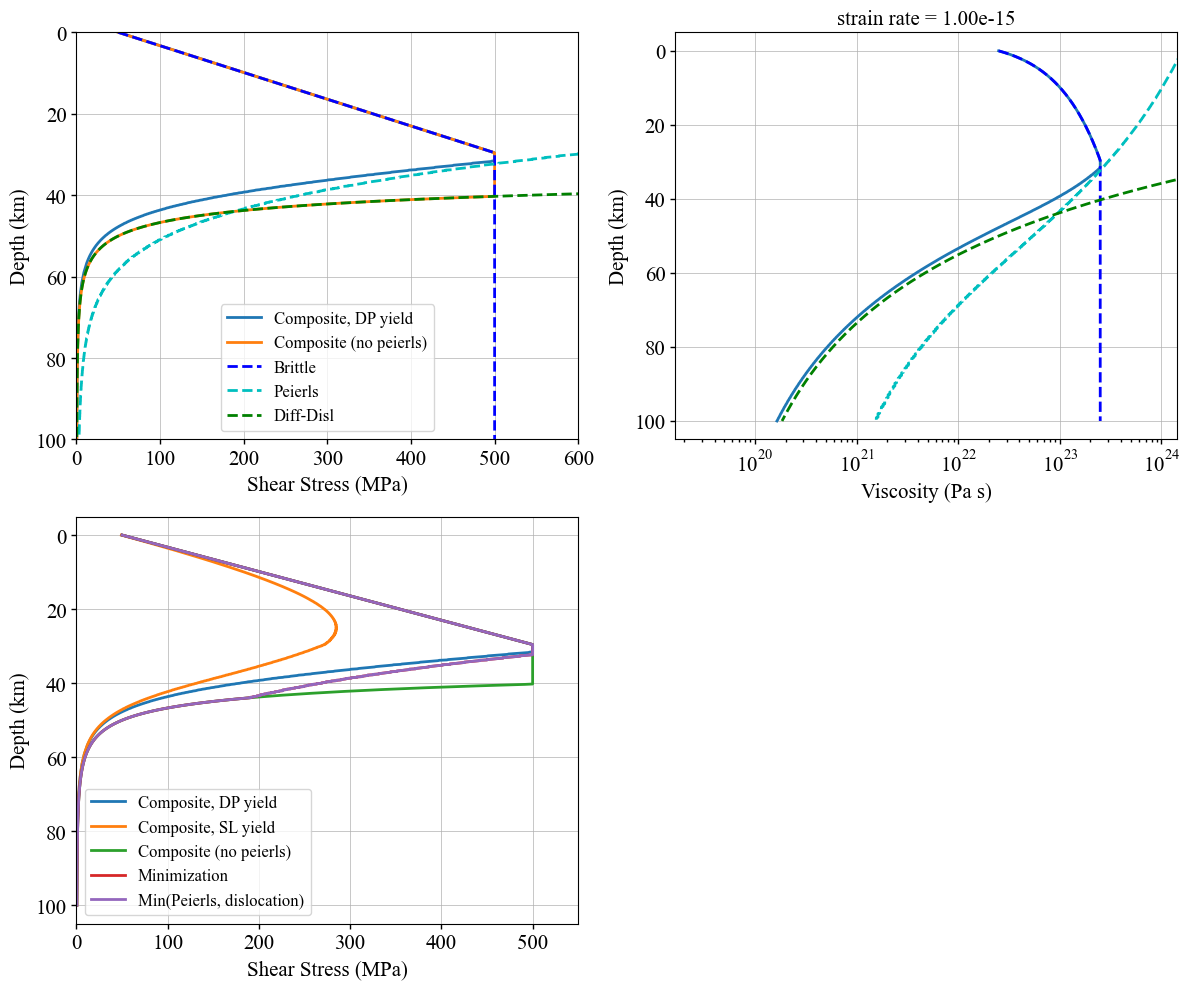

In [15]:
# define global parameters
g = 9.81
rho_m = 3300.0 # mantle density
year = 365.25 * 24 * 3600.0  # s in year
Myr = 1e6 * year

# pressure profile
zs_test = np.linspace(0.0, 100e3, 1000)
Ps = zs_test * rho_m * g

# thermal model
age = 80 * Myr
PlateModel = PLATE_MODEL(150e3, 1e-6, 273.15, 1673.0)
Ts = PlateModel.T(zs_test, age)

# strain rate to use
strain_rate = 1e-15

# brittle yielding
tau_0 = 50e6
tau_m = 500e6
friction = 0.47
taus_test_brittle = CoulumbYielding(Ps, tau_0, friction)
mask_limit = (taus_test_brittle > tau_m)
taus_test_brittle[mask_limit] = tau_m
eta_brittle = taus_test_brittle / 2.0 / strain_rate

# diffusion & dislocation creep
# here I took the parameterization for my 2d cases
da_file = os.path.join(LEGACY_FILE_DIR, 'reference_TwoD', "depth_average.txt")
assert(os.path.isfile(da_file))
Operator = RHEOLOGY_OPR()
Operator.ReadProfile(da_file)

diffusion_aspect = rheology_aspect['diffusion_creep']
eta_diffusion = CreepRheologyInAspectViscoPlastic(diffusion_aspect, strain_rate, Ps, Ts)
taus_diffusion = 2 * strain_rate * eta_diffusion
dislocation_aspect = rheology_aspect['dislocation_creep']
eta_dislocation = CreepRheologyInAspectViscoPlastic(dislocation_aspect, strain_rate, Ps, Ts)
taus_dislocation = 2 * strain_rate * eta_dislocation

eta_dfds = 1.0 / (1.0 / eta_diffusion + 1.0 / eta_dislocation)
taus_dfds = 2 * strain_rate * eta_dfds


# peierls creep
# refit peierls creep
dV = dislocation_aspect['V']
creep = GetPeierlsRheology("MK10")
taus_peierls = np.zeros(zs_test.size) # Mpa
for i in range(zs_test.size):
    taus_peierls[i] = PeierlsCreepStress(creep, strain_rate, Ps[i], Ts[i], dV=dV)
eta_peierls = taus_peierls * 1e6 / 2.0 / strain_rate

# print the value in the flow law
print("Diffusion creep (in UI): ")
print(diffusion_aspect)
print("Dislocation creep (in UI): ")
print(dislocation_aspect)
print("Peierls creep (not in UI): ")
print(creep)

# get the composite rheology
eta = 1.0 / (1.0/eta_brittle + 1.0/eta_peierls + 1.0/eta_dfds)
eta1 = np.minimum(eta_peierls, eta_dfds)  # minimum
eta1 = np.minimum(eta_brittle, eta1)
eta2 = np.minimum(eta_brittle, 1.0 / (1.0 / eta_peierls + 1.0/eta_dfds)) # DP yield
eta3 = np.minimum(eta_brittle, 1.0/(1.0 / np.minimum(eta_peierls, eta_dislocation) + 1.0 / eta_diffusion)) # competing Peierls and Dislocation
eta_nopc = np.minimum(eta_brittle, eta_dfds)
taus = 2 * strain_rate * eta
taus1 = 2 * strain_rate * eta1
taus2 = 2 * strain_rate * eta2
taus3 = 2 * strain_rate * eta3
taus_nopc = 2 * strain_rate * eta_nopc

# get the minimum
taus_minimum = np.minimum(taus_test_brittle, taus_peierls*1e6)
taus_minimum = np.minimum(taus_minimum, taus_dfds)

# Make figure better
MatplotlibFormatPrep()

# plot
# 1. shear stress vs depth
# 2. viscosity vs depth
# 3. shear stress vs depth
fig = plt.figure(tight_layout=True, figsize=(12, 10))
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, 0])
ax.plot(taus2/1e6, zs_test/1e3, label="Composite, DP yield")
ax.plot(taus_nopc/1e6, zs_test/1e3, label="Composite (no peierls)")
ax.plot(taus_test_brittle/1e6, zs_test/1e3, 'b--', label="Brittle")
ax.plot(taus_peierls, zs_test/1e3, 'c--', label="Peierls") # peierls is MPa
ax.plot(taus_dfds/1e6, zs_test/1e3, 'g--', label="Diff-Disl")
ax.set_xlabel("Shear Stress (MPa)")
ax.set_xlim([0, 600.0])
ax.set_ylim([0, 100.0])
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.legend()

ax = fig.add_subplot(gs[0, 1])
ax.semilogx(eta2, zs_test/1e3, label="Composite, DP yield")
ax.semilogx(eta_brittle, zs_test/1e3, 'b--', label="Brittle")
ax.semilogx(eta_peierls, zs_test/1e3, 'c--', label="Peierls")
ax.semilogx(eta_dfds, zs_test/1e3, 'g--', label="Diff-Disl")
ax.set_xlabel("Viscosity (Pa s)")
ax.set_xlim([np.amin(eta)/10.0, np.amax(eta)*10.0])
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.set_title("strain rate = %.2e" % strain_rate)

ax = fig.add_subplot(gs[1, 0])
ax.plot(taus2/1e6, zs_test/1e3, label="Composite, DP yield")
ax.plot(taus/1e6, zs_test/1e3, label="Composite, SL yield")
ax.plot(taus_nopc/1e6, zs_test/1e3, label="Composite (no peierls)")
ax.plot(taus1/1e6, zs_test/1e3, label="Minimization")
ax.plot(taus3/1e6, zs_test/1e3, label="Min(Peierls, dislocation)")
ax.set_xlabel("Shear Stress (MPa)")
ax.set_xlim([0, tau_m/1e6 * 1.1])
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.legend()

fig_path = os.path.join(package_root, "dtemp", "Peierls_Yielding_Compare_Strength_Profile_%.2e.pdf" % strain_rate)
fig.savefig(fig_path)
print("save figure: %s" % fig_path)

rcdefaults()